# Como leer un cubo de datos

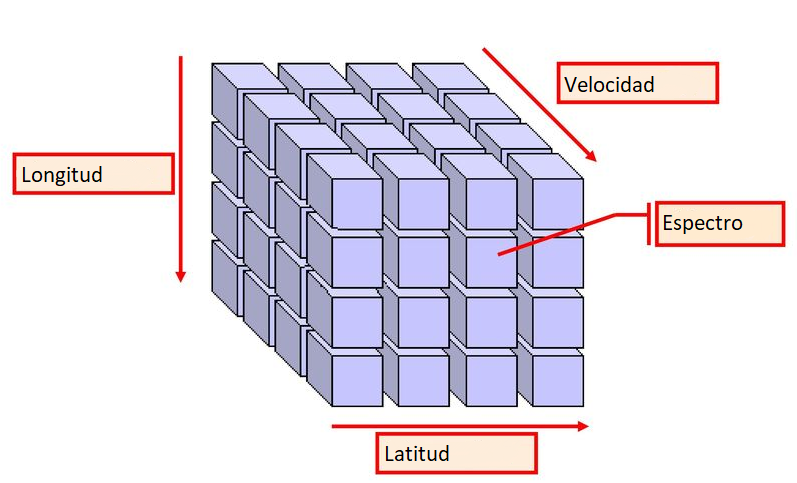

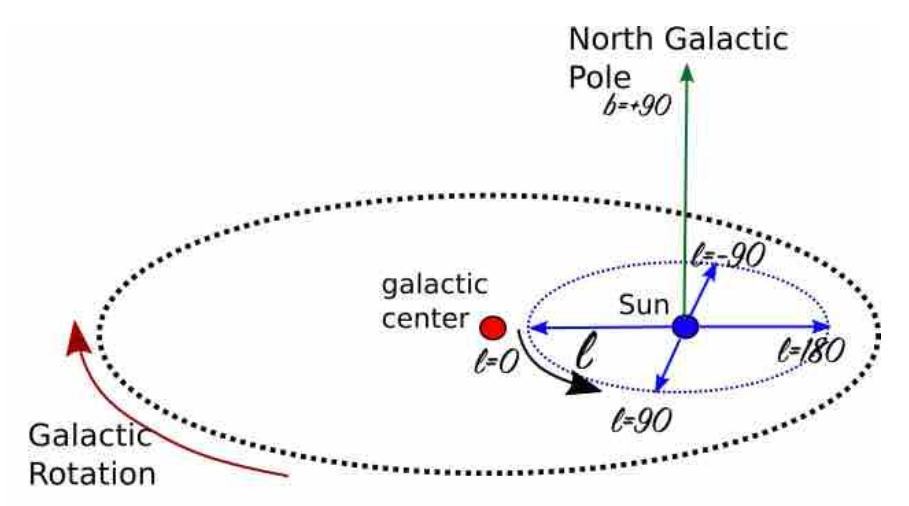

In [21]:
#import pyfits #modulo para leer archivos fits
from astropy.io import fits
import matplotlib.pyplot as plt #modulo para graficar
import numpy as np #este modulo es para trabajar con matrices como en matlab
import scipy as sp

#esta es una forma "automatizada" de obtener la velocidad(v) longitud(l) y latitud(b)
#esta funcion les entrega un arreglo con los valores reales del eje correspondiente
#1 es velocidad, 2 es longitud galactica, 3 es latitud galactica
def values(h,j):
	N=h['NAXIS'+str(j)];
	val=np.zeros(N);
	for i in range(0,N):
		val[i] = (i+1-float(h['CRPIX'+str(j)]))*float(h['CDELT'+str(j)]) + float(h['CRVAL'+str(j)]);
	return val;

cubo	= fits.open("cubo_de_datos.fits") #abrir objeto cubo de datos
data 	= cubo[0].data #extraer matriz de datos
header	= cubo[0].header #extraer el header del archivo fits


#Estos seran los tres arreglos con los valores reales de los tres ejes del cubo
velocidad=values(header,1)
longitud=values(header,2)
latitud=values(header,3)

#print ('v =',velocidad)
#print ('l =',longitud)
#print ('b =',latitud)

#esta es una forma manual de obtener v, l, b, leyendo el header
#velocidad= np.linspace(-230.7985, 165.8235, 306)
#longitud= np.linspace(300, 348., 385)
#latitud= np.linspace(-2, 2., 33)

## Ahora pueden trabajar con el cubo como si fuera una matriz

### Ejemplo 1, graficar el espectro localizado en l=325.00 y b=-0.25

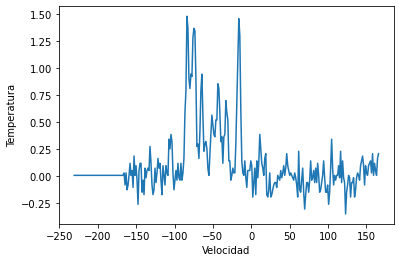

In [22]:
i_l=-1
i_b=-1
i_k=-1
#con este par de ciclos buscan en que indice esta la longitud y la latitud esperada
for i,lat in enumerate(latitud):
    if lat <= -0.25:
        i_b = i
for j,lon in enumerate(longitud):
    if lon <= 325.0:
        i_l = j


#ahora grafican el espectro
plt.plot(velocidad, data[i_b][i_l][:])
plt.xlabel('Velocidad')
plt.ylabel('Temperatura')

#cuidado pues para llamar en data el orden es indice lat, indice longitud, indice velocidad, al reves del orden del header
#plt.xlim(-100, 0)
plt.show()

# #Se grafica T vs. latitud para l=325.00 y b=-0.25
# plt.plot(latitud, aux)
# #plt.plot(latitud, data[:][i_l][i_k]) # Este no funciona
# #cuidado pues para llamar en data el orden es indice lat, indice longitud, indice velocidad, al reves del orden del header
# plt.show()

### Ejemplo 2, hacer un mapa de contornos de todo el cubo.


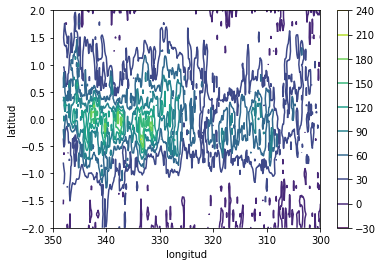

In [23]:
#Ejemplo 2, hacer un mapa de contornos de todo el cubo.
#Para esto integran en velocidad, colapsan el eje de velocidad para que les quede un fits en 2 dimensiones, latitud y longitud

data_2 = np.zeros((len(latitud),len(longitud))) #con esto crean un imagen con ceros de las dimensiones de latitud y longitud
for i in range(len(latitud)):
	for j in range(len(longitud)):
		data_2[i][j] = sum(data[i][j][:])
#plotean los contornos


fig2=plt.figure()
plt.xlabel('longitud')
plt.ylabel('latitud')
plt.contour(longitud,latitud,data_2)
plt.xlim(350, 300)
plt.colorbar()
plt.show()


### Ejemplo 3, hacer un mapa del cubo.

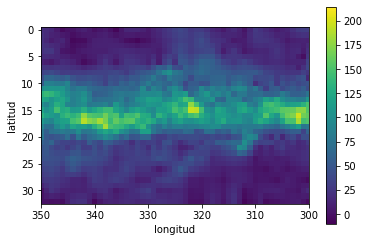

In [24]:
#Igual que el ejemplo 2, pero sin contornos
plt.imshow(data_2)
#plt.matshow(data_2)
plt.xlabel('longitud')
plt.ylabel('latitud')
plt.colorbar()
plt.xlim(350, 300)
plt.show()


### Ejemplo 4: Se hace un mapa de longitud vs. velocidad

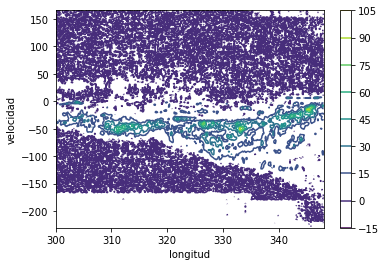

In [25]:
data_3 = np.zeros((len(velocidad),len(longitud))) 
for i in range(len(velocidad)):
    for j in range(len(longitud)):
        # Es necesario crear un arreglo auxiliar con los valores para cada b, dado un l,v
        aux=np.zeros(33)
        for h in range(33):
            aux[h]=data[h][j][i]
        data_3[i][j] = sum(aux)
#plotean los contornos
fig2=plt.figure()
plt.contour(longitud,velocidad,data_3)
plt.xlabel('longitud')
plt.ylabel('velocidad')
#plt.xlim(350, 300)
plt.colorbar()
plt.show()

## Maneras de Separar Ruido de Senal

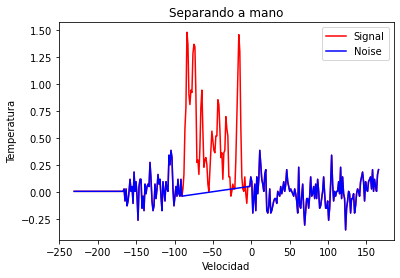

In [26]:
# Se hace al ojo
ruido = np.where((velocidad <= -90) | (velocidad >= -4)) #otra forma es T>0.5  
T = data[i_b][i_l][:]
plt.plot(velocidad, T, color='r', label='Signal') 
plt.plot(velocidad[ruido], T[ruido], color='b', label='Noise')
plt.legend()
plt.xlabel('Velocidad')
plt.ylabel('Temperatura')
plt.title('Separando a mano')
plt.show()

v_terminla con mascara = -86.45409999999998


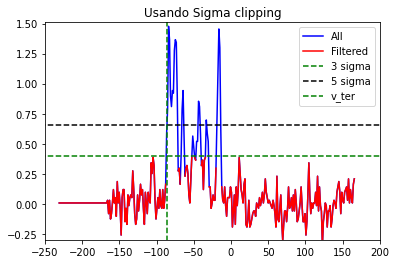

v_terminal sin mascara = -86.45409999999998


In [27]:
# Usando Sigma clipping
from astropy.stats import sigma_clip

#r = sigma_clip(T, sigma=3)
r = sigma_clip(T, sigma_lower=3, sigma_upper=3)
rms = np.sqrt(np.mean(r**2))
rmask = r.mask
v_terminal = velocidad[rmask][0]
print ('v_terminla con mascara =', v_terminal)
plt.plot(velocidad, T, color='b', label='All')
plt.plot(velocidad, r, color='r', label='Filtered')
plt.plot([-300,300],[3*rms,3*rms], 'g--', label='3 sigma')
plt.plot([-300,300],[5*rms,5*rms], 'k--', label='5 sigma')
plt.plot([v_terminal,v_terminal],[-10,10], 'g--', label='v_ter')
plt.xlim(-250,200)
plt.ylim(-0.3,1.51)
plt.legend()
plt.title('Usando Sigma clipping')
plt.show()

# Se encuentra V_terminal cuando no se tiene mascara
v_terminal = np.nan
for i in range(len(T)):
    temp = T[i]
    if temp >= 3*rms:
        v_terminal = velocidad[i]
        break
print( 'v_terminal sin mascara =', v_terminal)


## Curva de rotacion

#### Partimos de la expresion para la Velocidad de local standard of rest

\begin{align}
V_{LSR} = R_{0} sin(l)[\omega(R) - \omega(R_{0}) ] 
\end{align}

#### Donde R0 es la distancia radial del Sol al centro de la galaxia, l la longitud y ω(R) es la velocidad angular con respecto al centro de la galaxia
#### Donde V(R_0) es la velocidad del sol respecto al centro galáctico, el valor de esta constante, corresponde a 220[km/s]. Ademas se puede calcular omega(R_0) como:

\begin{align}
\omega_0 = V(R_0)R_0
\end{align}

#### Con R_0=8.5kpc

#### Sin embargo, lo que se busca para realizar el calculo necesario son los máximos V_LSR, para esto senecesitan las velocidades tangenciales que ocurren cuando R = R0sin(l), por lo tanto se ocupara

\begin{align}
V^{max}_{LSR} =R0sin(l)[ω(R0sin(l)) − ω(R0)]
\end{align}


#### Valor que se calcula para cada punto del espectro, eligiendo para una longitud fija, la latitud que entregue el valor mas negativo entre todas las longitudes, así se puede calcular la velocidad de rotación como:

\begin{align}
\omega(R=R_0 sin(l)) = \frac{V_{LSR}^{MAX}}{R_0 sin(l)} + \omega(R_0) 
\end{align}



#### El signo - de la Vlsr se anula con el signo - de sin(l) en esta ecuación, en el cuarto cuadrante de longitud donde estamos trabajando (360 > l > 270)


#### Luego se obtiene la curva de velocidad de rotación como:


\begin{align}
V (R=R_0 sin(l)) =   \frac{V_{LSR}^{MAX} |sin(l)|}{sin(l)} + V(R_0) |sin(l)|
\end{align}

#### O tambien como:
\begin{align}
V (R=R_0 sin(l)) =  \omega (R=R_0 sin(l)) \cdot R_0 · |sin(l)| 
\end{align}

#### V(R) debe ser positivo por eso el valor absoluto en el seno


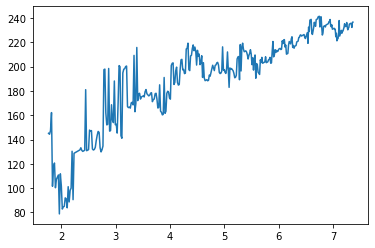

In [32]:
# Se crea una funcion que para un indice de longitud(l) fija, se recorre latitud(b) y se calcula el rms de las
# velocidades
# Esta misma funcion recorre el cubo de las velocidades asociadas a l y b, hasta que se llega a una
# velocidad que es 5 veces mayor que el rms, esta ultima se guarda un arreglo

def fmin(l, vs):
    #recorre latitud
    for q in range(33):
        T1=data[q][l][:]
        rms=np.sqrt(np.mean(T1**2))   #calcula rms
        #recorre velocidad
        for w in range(306):
            if data[q][l][w]>=5*rms:  #buscamos que no sea ruido
                vs[q]=velocidad[w]    #guardamos la primera v donde T mayor a 5rms
                break

vmin=np.zeros(385)
bvmin=np.zeros(385)
R=np.zeros(385)
R0=8.5 #kPc
vsol=220 #km/s

#maximorum
# Se recorren las longitudes y se busca la velocidad más negativa (mayor en modulo), se guarda esta
# y su latitud asociada
# Se obtiene un arreglo de R con la ecuacion R =| R0 · cos(l π/180 ) |

for i in range(385):
    vs=np.zeros(33)
    fmin(i, vs)
    v1=vs[0]
    b1=latitud[0]
    for j in range(32):
        if vs[j+1]<v1:
            v1=vs[j+1]
            b1=latitud[j+1]
    vmin[i]=v1
    bvmin[i]=b1
    R[i]=np.abs(R0*np.sin(longitud[i]*sp.pi/180.)) #R0*sin(l)

    
# Se obtiene la Vtan con Vtan = −Vmin − Vsol · sin(lπ/180 ), donde Vmin es la velocidad mayor en
# modulo para l, y Vsol es la velocidad de rotacion del sol.    
#velocidad de rotacion

vR=np.zeros(385)
for i in range(385):
    vR[i]= vmin[i]*(np.abs(np.sin(longitud[i]*np.pi/180.))/np.sin(longitud[i]*sp.pi/180.)) + np.abs(vsol*np.sin(longitud[i]*np.pi/180.))
    
plt.plot(R, vR)
plt.show()

## Corrugacion del disco galactico

Previamente Para cada l, calculamos $b_{max}$ que es la latitud donde se alcazna el maximo maximorum.

Podemos calcular Z(R), la corrugacion del plano galactico como:

\begin{align}
Z (R=R_0 sin(l)) =   R_0 cos(l) tan(b_{max}) \approx  R_0 cos(l)b_{max}
\end{align}


## Modelos de distribución de masa para la curva de rotación


En la siguientes celdas veremos como ajustar un modelo de masa a la curva de rotación de la galaxia. Si asumimos que la galaxia tiene un perfil de masa M(r), entonces su velocidad será:

\begin{align}
v(r) =   \frac{GM(r)}{R}
\end{align}


Veremos el caso de una masa puntual $M_{0}$, para este caso tendremos que la velocidad puede expresarse en funcion del radio como:

\begin{align}
v(r) =   \frac{GM_{0}}{R}
\end{align}

Ajustaremos este modelo de distribucion de masa ocupando curve_fit de scipy

In [12]:
from scipy.optimize import curve_fit

#definimos la constante G en unidades adecuadas
G=4.302e-6 # Units: pc x M_sun^(-1) x (km/s)^2 

def masapuntual(R,M0):
    M=M0
    v=sp.sqrt(G*M/R)
    return v

mpuntual,covmpuntual=curve_fit(masapuntual, R, vR)

print("M0: " +  "{:.3e}".format(mpuntual[0]) + " masas solares")

M0: 3.228e+10 masas solares


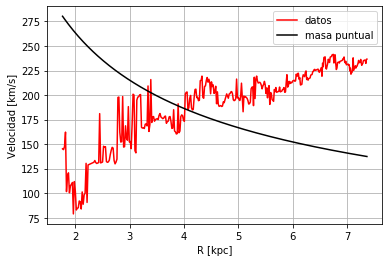

In [13]:
#Graficamos el ajuste

plt.plot(R, vR, 'r',label='datos')
plt.plot(R, masapuntual(R,mpuntual[0]),'k',label='masa puntual')
plt.xlabel('R [kpc]')
plt.ylabel('Velocidad [km/s]')
plt.grid()
plt.legend()
plt.show()